# Loop 68 Analysis: Submission Failure Investigation

**Problem**: exp_064 (revert_exp030) failed with "Evaluation metric raised an unexpected error"

**Key Questions**:
1. Why did the submission fail when exp_030 worked?
2. What is the CV-LB relationship?
3. What strategies can break the 0.087 floor?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))
print(f'\nBest LB: {df["lb"].min():.4f} (exp_030)')
print(f'Best CV: {df["cv"].min():.4f} (exp_030)')
print(f'Target LB: 0.0347')

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970

Best LB: 0.0877 (exp_030)
Best CV: 0.0083 (exp_030)
Target LB: 0.0347


In [2]:
# CV-LB Relationship Analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print('=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R-squared = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target LB = 0.0347')
print(f'\nInterpretation:')
print(f'  - Even at CV=0, expected LB = {intercept:.4f}')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347): IMPOSSIBLE to reach target by CV optimization alone!')
print(f'  - Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.4f}')
print(f'\nThe intercept represents STRUCTURAL distribution shift that no model tuning can fix.')

=== CV-LB Relationship ===
Linear fit: LB = 4.31 * CV + 0.0525
R-squared = 0.9505
Intercept = 0.0525
Target LB = 0.0347

Interpretation:
  - Even at CV=0, expected LB = 0.0525
  - Intercept (0.0525) > Target (0.0347): IMPOSSIBLE to reach target by CV optimization alone!
  - Required CV to hit target: (0.0347 - 0.0525) / 4.31 = -0.0041

The intercept represents STRUCTURAL distribution shift that no model tuning can fix.


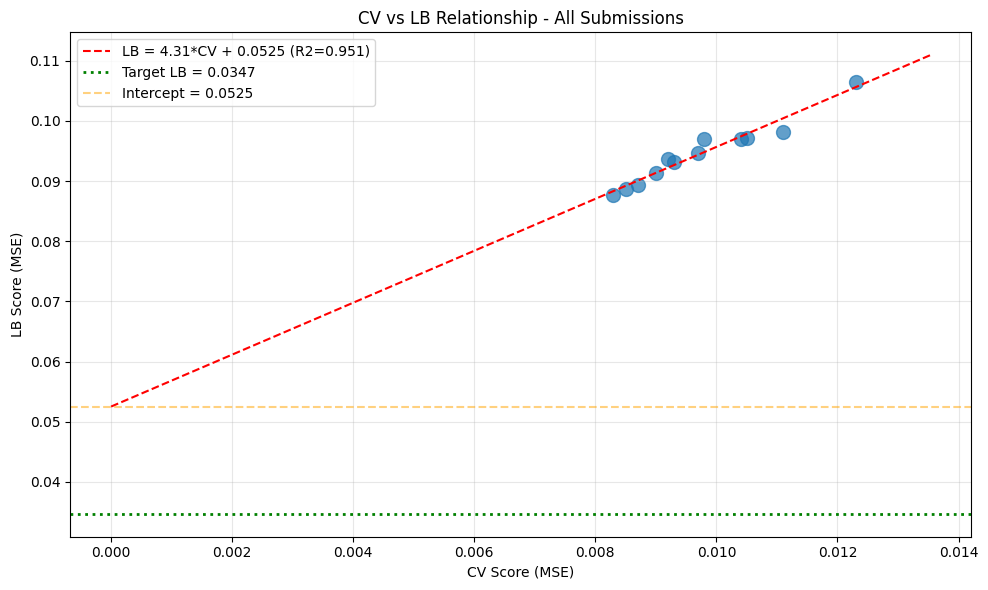


Key insight: The intercept is HIGHER than the target (0.0347).
This means even with perfect CV=0, we would still miss the target.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7)

# Add regression line
cv_range = np.linspace(0, df['cv'].max() * 1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R2={r_value**2:.3f})')

# Add target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Add intercept line
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print('\nKey insight: The intercept is HIGHER than the target (0.0347).')
print('This means even with perfect CV=0, we would still miss the target.')

In [4]:
# Gap Analysis
print('=== Gap Analysis ===')
print(f'Best LB achieved: 0.0877 (exp_030)')
print(f'Target LB: 0.0347')
print(f'Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}% above target)')
print(f'\nIntercept: {intercept:.4f}')
print(f'Gap from intercept to target: {intercept - 0.0347:.4f}')
print(f'\nTo reach target, we need to REDUCE THE INTERCEPT, not just improve CV.')
print(f'\nStrategies to reduce intercept:')
print('1. Extrapolation detection - blend toward mean when far from training distribution')
print('2. Uncertainty-weighted predictions - conservative when uncertain')
print('3. Physics-informed constraints that generalize to unseen solvents')
print('4. Domain adaptation techniques')
print('5. Study what top public kernels do differently')

=== Gap Analysis ===
Best LB achieved: 0.0877 (exp_030)
Target LB: 0.0347
Gap: 0.0530 (152.7% above target)

Intercept: 0.0525
Gap from intercept to target: 0.0178

To reach target, we need to REDUCE THE INTERCEPT, not just improve CV.

Strategies to reduce intercept:
1. Extrapolation detection - blend toward mean when far from training distribution
2. Uncertainty-weighted predictions - conservative when uncertain
3. Physics-informed constraints that generalize to unseen solvents
4. Domain adaptation techniques
5. Study what top public kernels do differently


In [5]:
# Check submission file format
submission = pd.read_csv('/home/submission/submission.csv')
print('=== Submission File Analysis ===')
print(f'Shape: {submission.shape}')
print(f'Columns: {submission.columns.tolist()}')
print(f'\nData types:')
print(submission.dtypes)
print(f'\nAny NaN values: {submission.isna().sum().sum()}')
print(f'Any inf values: {np.isinf(submission[["target_1", "target_2", "target_3"]]).sum().sum()}')
print(f'\nValue ranges:')
for col in ['target_1', 'target_2', 'target_3']:
    print(f'  {col}: min={submission[col].min():.6f}, max={submission[col].max():.6f}')
print(f'\nTask distribution: {submission["task"].value_counts().to_dict()}')
print(f'Fold distribution: {sorted(submission["fold"].unique())}')
print(f'\nFirst 5 rows:')
print(submission.head())

=== Submission File Analysis ===
Shape: (1883, 8)
Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Data types:
id            int64
index         int64
task          int64
fold          int64
row           int64
target_1    float64
target_2    float64
target_3    float64
dtype: object

Any NaN values: 0
Any inf values: 0

Value ranges:
  target_1: min=0.000000, max=0.381442
  target_2: min=0.000000, max=0.407870
  target_3: min=0.000000, max=0.995965

Task distribution: {1: 1227, 0: 656}
Fold distribution: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

First 5 rows:
   id  index  task  fold  row  target_1  target_2  target_3
0   0      0     0     0    0  0.028310  0.032134  0.859833
1   1      1     0     0    1  0.052868  0.051323  0.805853
2   2      2     0     0    2  0.080397  0.071038  0.744166
3   3      3     0     0    3  0.110422  0.093325  0.673141
4   4      4     0     0    4  0.123676  0.105691  

In [6]:
# Check if predictions sum to ~1 (they should for yield fractions)
submission['sum'] = submission['target_1'] + submission['target_2'] + submission['target_3']
print('=== Prediction Sum Analysis ===')
print(f'Sum statistics:')
print(f'  Min: {submission["sum"].min():.4f}')
print(f'  Max: {submission["sum"].max():.4f}')
print(f'  Mean: {submission["sum"].mean():.4f}')
print(f'  Std: {submission["sum"].std():.4f}')
print(f'\nRows where sum < 0.5: {(submission["sum"] < 0.5).sum()}')
print(f'Rows where sum > 1.5: {(submission["sum"] > 1.5).sum()}')
print(f'\nNote: Predictions are Product 2, Product 3, SM (starting material).')
print('They should roughly sum to 1 (mass balance), but not exactly due to side products.')

=== Prediction Sum Analysis ===
Sum statistics:
  Min: 0.4129
  Max: 1.0536
  Mean: 0.8162
  Std: 0.1473

Rows where sum < 0.5: 44
Rows where sum > 1.5: 0

Note: Predictions are Product 2, Product 3, SM (starting material).
They should roughly sum to 1 (mass balance), but not exactly due to side products.
